# Investigating changes in mixed layer depth at Sørvest-F  due to wind farms

__Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute__

#### The project - Havvind

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 5 different farms simulated along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 1x1500MW (430 km²) + 2x2100MW (600km² + 600 km²)
* 258 turbines

### Mixed layer depth

The mixed layer of the upper ocean is the first meters of the water column where the potential density is fairly mixed. Below this layer, the density increases almost exponentially. The depth of the mixed layer depends on available energy for mixing, i.e. turbulence and convection.

As in Treguier et al. (2023), I will use the potential density threshold method to determine the MLD. 


Treguier, A. M., de Boyer Montégut, C., Bozec, A., Chassignet, E. P., Fox-Kemper, B., McC. Hogg, A., Iovino, D., Kiss, A. E., Le Sommer, J., Li, Y., Lin, P., Lique, C., Liu, H., Serazin, G., Sidorenko, D., Wang, Q., Xu, X., and Yeager, S.: The mixed-layer depth in the Ocean Model Intercomparison Project (OMIP): impact of resolving mesoscale eddies, Geosci. Model Dev., 16, 3849–3872, https://doi.org/10.5194/gmd-16-3849-2023, 2023.

In [12]:
%load_ext autoreload
%autoreload 2

from Mixed_layer_depth.mld import *
from Rossby_deformation.get_turbine_coords import get_turbine_coords
from Rossby_deformation.density import dens
from Rossby_deformation.funcs import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Making a grid
path = '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-03/norkyst_avg_0001.nc'
fid = Dataset(path)
grid = SGrid(fid)
del fid

In [3]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [4]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF')

# Only using June because we want the largest Rossby radius
months = {
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [5]:
# Square around wind park
min_lon_SV = np.min(sorvest_F.coordinates[:,0].values)
min_lat_SV = np.min(sorvest_F.coordinates[:,1].values)
max_lon_SV = np.max(sorvest_F.coordinates[:,0].values)
max_lat_SV = np.max(sorvest_F.coordinates[:,1].values)

area_lon_SV = [min_lon_SV, max_lon_SV]
area_lat_SV = [min_lat_SV, max_lat_SV]

In [6]:
R1_june_SV = monthly_mean_area(files, grid, area_lon_SV, area_lat_SV).mean(dim='ocean_time')

Plan:
- Read in a dataset
- Subset it on the study area by using the R1
- Compute potential density on z levels
- Make function for calculating MLD

- When the above works, write a script that opens all files, computes potential density on zlevs, computes mixed layer depth at all grid points, writes daily files containing the mixed layer depth.
- Then I can read the files in, subset based of area, and visualize.

In [7]:
testfile = '/home/kjsta7412/sommer_25/MET_sommer25/output_mld/tests/norkyst_avg_0001_mld.nc'

In [8]:
mld_ds = xr.open_dataset(testfile)

In [9]:
mld_ds.mld

<xarray.DataArray 'mld' (ocean_time: 1, eta_rho: 1148, xi_rho: 2747)>
[3153556 values with dtype=float64]
Coordinates:
  * ocean_time  (ocean_time) float64 1.654e+09
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  Mixed layer depth
    units:      meter

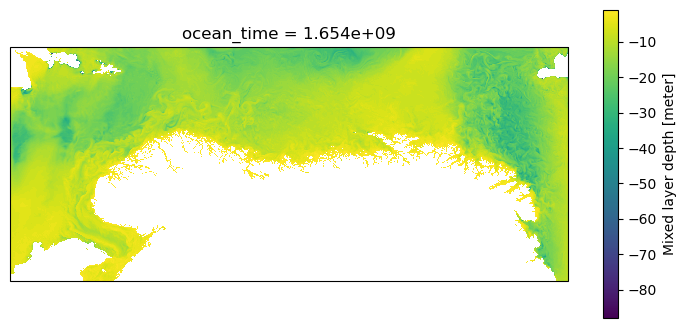

In [16]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(9, 4), subplot_kw={'projection':proj})

mld_ds.mld.isel(ocean_time=0).plot(ax=ax)

In [17]:
testfile2 = '/home/kjsta7412/sommer_25/MET_sommer25/output_mld/tests/_norkyst_avg_0001_mld.nc'
mld_ds_2 = xr.open_dataset(testfile2)

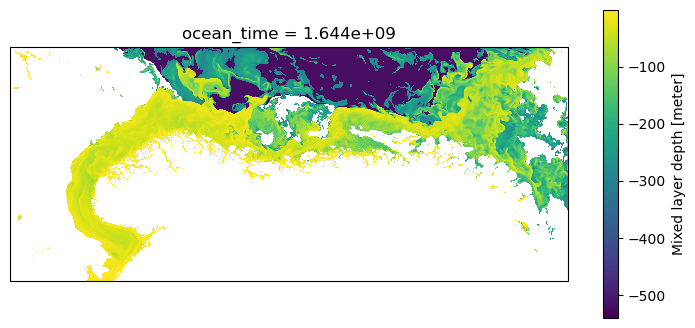

In [18]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(9, 4), subplot_kw={'projection':proj})

mld_ds_2.mld.isel(ocean_time=0).plot(ax=ax)

In [20]:
# If mld exceeds local water depth, mld is set to local water depth
testfile3 = '/home/kjsta7412/sommer_25/MET_sommer25/output_mld/tests/REF_02_norkyst_avg_0001_mld.nc'
mld_ds_3 = xr.open_dataset(testfile3)

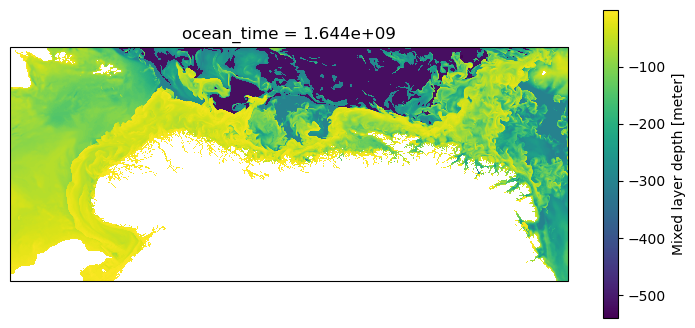

In [21]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(9, 4), subplot_kw={'projection':proj})

mld_ds_3.mld.isel(ocean_time=0).plot(ax=ax)

In [25]:
d = mld_ds_3.mld.isel(ocean_time=0) - mld_ds_2.mld.isel(ocean_time=0).fillna(0)

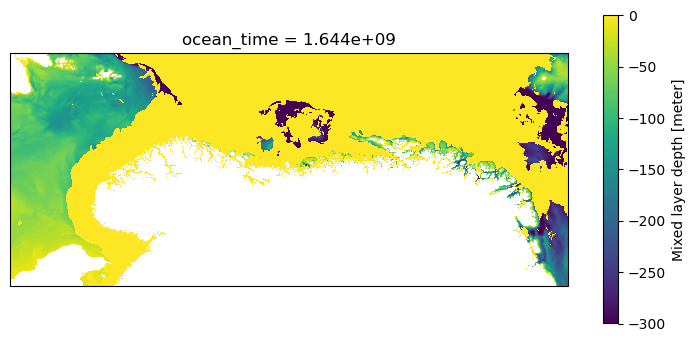

In [26]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(9, 4), subplot_kw={'projection':proj})

d.plot(ax=ax)